In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torchvision.transforms import functional as F
from scipy.ndimage import rotate
import time
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from tqdm.auto import tqdm
from torchvision.transforms import v2

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Define a custom dataset
class CSVDataset(Dataset):
    def __init__(self, csv_file):
        # Load the data
        self.data = pd.read_csv(csv_file)

    def __getitem__(self, index):
        # Get the data for one example
        example_data = self.data.iloc[index]
        # Separate the features from the target
        features = torch.tensor(example_data[2:].values, dtype=torch.float32).reshape(1, 28, 28)
        target = torch.tensor(example_data.iloc[1], dtype=torch.long)
        return features, target

    def __len__(self):
        return len(self.data)
    
    def classes(self, index):
        return self.data.iloc[index].iloc[1]


# Create instances of the dataset
train_data = CSVDataset('final_dataset/train_dataset.csv')
test_data = CSVDataset('final_dataset/test_dataset.csv')

In [4]:
image, label = train_data[1134]
label.item(), image.shape

(9, torch.Size([1, 28, 28]))

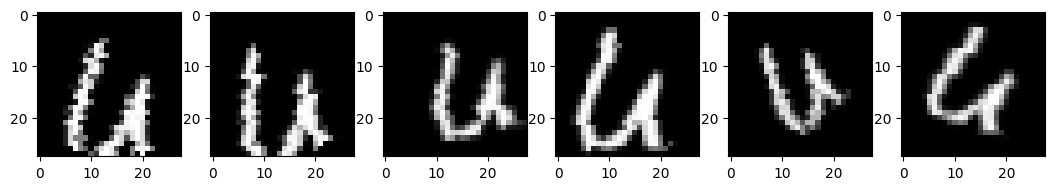

In [5]:
number = random.randint(0,len(train_data))

image, label = train_data[number]

transforms = v2.Compose([v2.RandomCrop(size = (28, 28), padding=(3,3)),
                         v2.RandomRotation(degrees=25),
                         v2.RandomAffine(degrees=20),
                         v2.RandomPerspective(distortion_scale=0.34)])

imgs = [[transforms(image) for _ in range(6)]]


fig, axs = plt.subplots(1, 6, figsize=(13, 13))  # Create a subplot with 1 row and 4 columns
for i, img in enumerate(imgs[0]):  # Loop over the augmented images
    axs[i].imshow(np.array(img).squeeze(), cmap='gray')  # Plot the image
plt.show()

In [6]:
class AugmentedDataset(Dataset):
    def __init__(self, original_dataset, transforms):
        self.original_dataset = original_dataset
        self.transforms = transforms

    def __getitem__(self, index):
        img, label = self.original_dataset[index]
        return self.transforms(img), label

    def __len__(self):
        return len(self.original_dataset)


In [7]:
augmented_train_data = AugmentedDataset(train_data, transforms)

In [8]:
classes_list = set()
for i in range(len(test_data)):
    _, target = test_data[i]
    classes_list.add(target.item())

classes_list

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61}

In [9]:
len(classes_list)

62

In [10]:
BATCH_SIZE = 32

combined_train_data = ConcatDataset([train_data, augmented_train_data])

train_dataloader = DataLoader(combined_train_data, #Dataset to iterate on for the according batch size.
                              batch_size = BATCH_SIZE, #Size of every single iteration.
                              shuffle = True, #To make the loaded data selected randomly.
                              )
test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = True)

print(f"For training data there is {len(train_dataloader)} iterations with the batch size of {BATCH_SIZE}.")
print(f"For testing data there is {len(test_dataloader)} iterations with the batch size of {BATCH_SIZE}.")

For training data there is 23057 iterations with the batch size of 32.
For testing data there is 1951 iterations with the batch size of 32.


In [11]:
import torch
from torch import nn

import torch
from torch import nn

class LetterRecognizerModel1(nn.Module):
    def __init__(self, input_size, output_size):
        super(LetterRecognizerModel1, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_size, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.55),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.55),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.55)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128*3*3, 512),
            #nn.BatchNorm4d(512),
            nn.Dropout(0.25),
            
            nn.Linear(512, 256),
            #nn.BatchNorm4d(256),
            nn.Dropout(0.55),
            
            nn.Linear(256, output_size)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc_layers(x)
        return x

torch.manual_seed(42)

model_1 = LetterRecognizerModel1(input_size=1, output_size=len(classes_list)).to(device)

model_1

LetterRecognizerModel1(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.55, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.55, inplace=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1)

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                             lr=0.001,
                             weight_decay=0.1)

In [13]:
def accuracy_func(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [14]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time
# Imported from learnpytorch.io directly...

In [15]:
def train_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  train_loss, train_acc = 0 , 0
  model.to(device)

  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device) , y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_func(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss is:{train_loss:.5f}, Train accuracy is:{train_acc:.2f}%")
  return train_loss, train_acc

def test_part(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_func,
               device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:

      X, y = X.to(device), y.to(device)

      test_pred = model(X)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_func(y_true=y,
                                y_pred = test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss is:{test_loss:.6f}, Test accuracy is:{test_acc:.6f}%")
  return test_loss, test_acc

In [16]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_1 = timer()

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Train and test model
epochs = 50
for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_part(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_func=accuracy_func,
        device=device)
    test_loss, test_acc = test_part(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer = optimizer,
        accuracy_func=accuracy_func,
        device=device)
    train_losses.append(train_loss.detach().cpu().numpy())
    train_accuracies.append(train_acc)
    test_losses.append(test_loss.detach().cpu().numpy())
    test_accuracies.append(test_acc)


    print(f"Epoch: {epoch}\n---------")

train_time_end_model_1 = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_model_1,
                                           end=train_time_end_model_1,
                                           device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Train loss is:2.11448, Train accuracy is:45.87%
Test loss is:1.373443, Test accuracy is:62.439134%
Epoch: 0
---------
Train loss is:nan, Train accuracy is:63.33%
Test loss is:nan, Test accuracy is:1.701051%
Epoch: 1
---------
Train loss is:nan, Train accuracy is:1.74%
Test loss is:nan, Test accuracy is:1.701051%
Epoch: 2
---------


KeyboardInterrupt: 

>>Train loss is:0.30203, Train accuracy is:88.36%
Test loss is:0.429774, Test accuracy is:84.104396%
Epoch: 16
---------
>>Train loss is:0.29569, Train accuracy is:88.55%
Test loss is:0.442328, Test accuracy is:83.710907%
Epoch: 17
---------
>>Train loss is:0.28920, Train accuracy is:88.73%
Test loss is:0.442030, Test accuracy is:84.589849%
Epoch: 18
---------
>>Train loss is:0.28300, Train accuracy is:89.00%
Test loss is:0.478287, Test accuracy is:83.507114%
Epoch: 19
---------
>>Train time on cuda: 6481.839 seconds

In [ ]:
# Second model is

>Train loss is:0.64897, Train accuracy is:78.31%
>Test loss is:0.675109, Test accuracy is:77.206165%
>Epoch: 14
---------
>Train loss is:0.64805, Train accuracy is:78.31%
>Test loss is:0.701849, Test accuracy is:76.739938%
>Epoch: 15
---------
>Train loss is:0.64689, Train accuracy is:78.38%
>Test loss is:0.689999, Test accuracy is:76.463407%
>Epoch: 16
---------
>Train loss is:0.64639, Train accuracy is:78.39%
>Test loss is:0.718036, Test accuracy is:75.148039%
>Epoch: 17
---------
>Train loss is:0.64603, Train accuracy is:78.41%
>Test loss is:0.717155, Test accuracy is:76.604076%
>Epoch: 18
---------
>Train loss is:0.64524, Train accuracy is:78.46%
>Test loss is:0.866036, Test accuracy is:73.586901%
>Epoch: 19
---------
>Train time on cuda: 44643.713 seconds

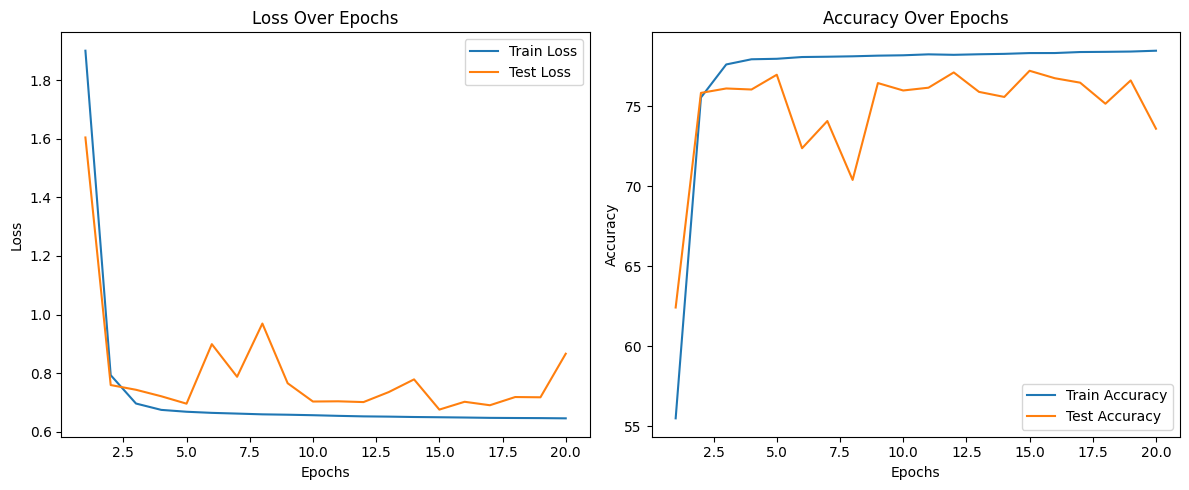

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()